In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("completed_Apples_stock price dataset.csv" )
df.head(3)

,Unnamed: 0.1,Unnamed: 0,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment,date,time
0,0,4,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077,2010-01-01,04:00:00
1,1,5,2010-01-01 05:00:00,99.022103,8011.832789,3004.510779,2.321292,4.095568,1.664753,-0.828119,2010-01-01,05:00:00
2,2,6,2010-01-01 06:00:00,108.127409,8028.157784,3010.735533,2.626140,5.447153,2.995546,-0.813849,2010-01-01,06:00:00


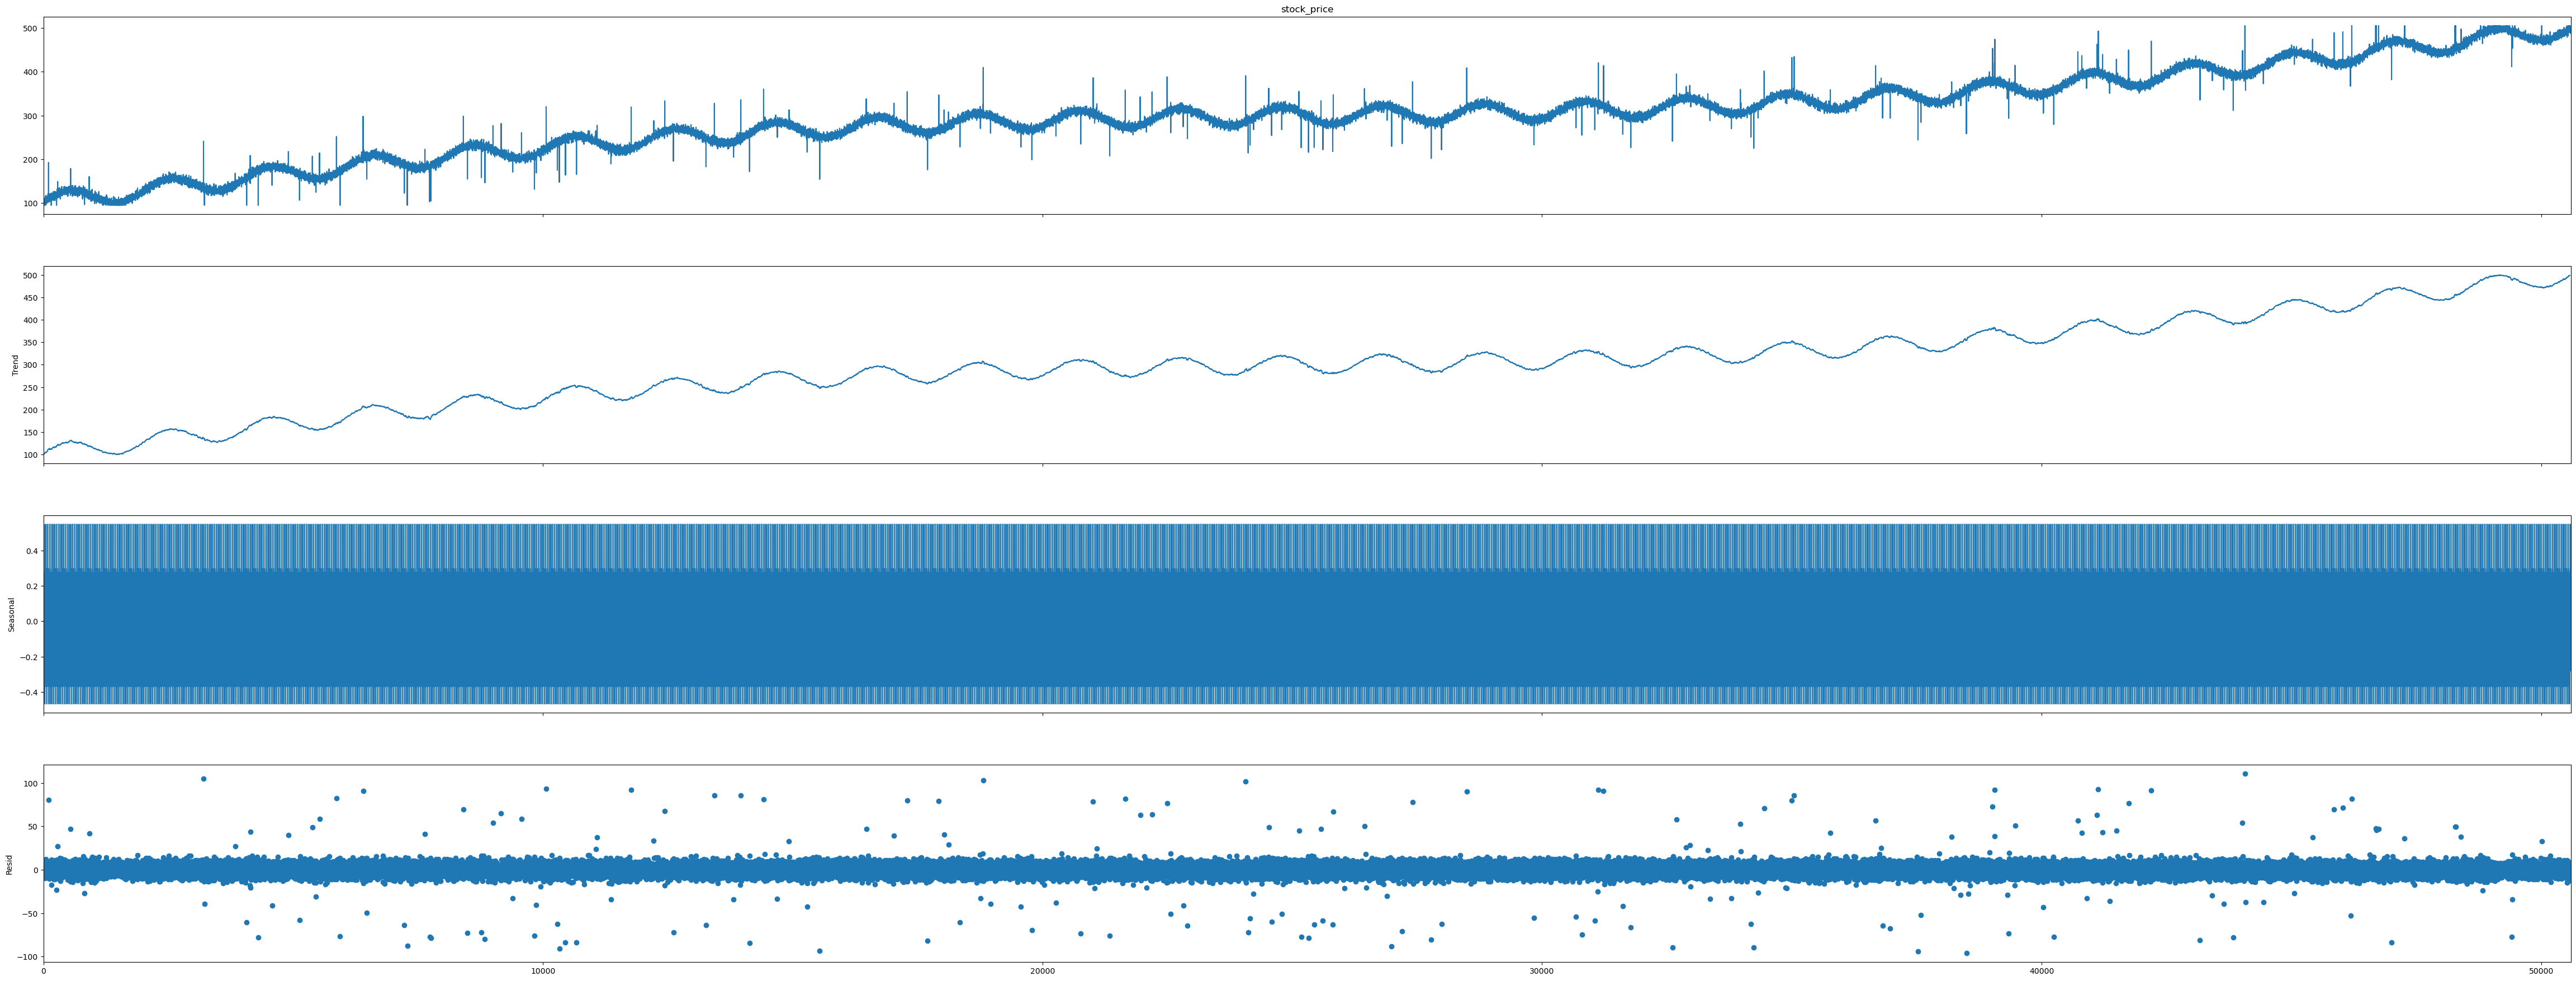

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
#plt.figure(figsize=(15,8))
decomp = seasonal_decompose(df['stock_price'], model='additive', period=36)
fig = decomp.plot()

fig.set_size_inches(55, 20) 
plt.show()

In [4]:
# Example: 80% train, 20% test
train_size = int(len(df) * 0.8)
train, test = df['stock_price'][:train_size], df['stock_price'][train_size:]
train.shape, test.shape

((40473,), (10119,))

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['stock_price'])
print('ADF  Statistic:', result[0])
print('p-value:', result[1])

ADF  Statistic: -0.44839334665171937
p-value: 0.9016998996368157


p-val > 0.05; <br> which means data is non-stationary. <br>
Differencing or log_transform needed

In [6]:
from statsmodels.tsa.stattools import kpss

# Perform the KPSS test
result = kpss(df['stock_price'])

print('KPSS Statistic:', result[0])
print('p-value:', result[1])

KPSS Statistic: 32.82076800400852
p-value: 0.01


C:\Users\YOGITA\AppData\Local\Temp\ipykernel_18980\3312324078.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df['stock_price'])


p-val < 0.05; <br>
which means data is non-stationary.<br>
Differencing or log_transform needed

In [7]:
stock_diff = df['stock_price'].diff().dropna()
stock_diff.head()

1    0.038639
2    9.105306
3   -4.020334
4   -6.145990
5    5.098727
Name: stock_price, dtype: float64

In [8]:
result = adfuller(stock_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -50.02011780106861
p-value: 0.0


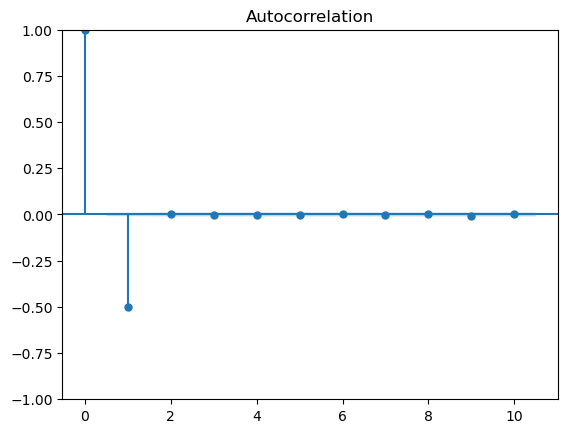

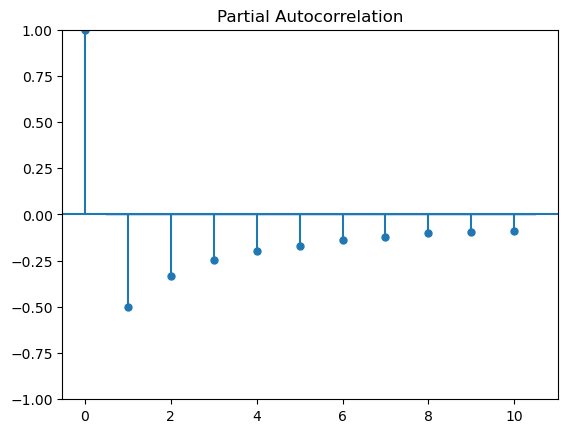

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# 6. Plot ACF and PACF to choose p and q
plot_acf(stock_diff, lags=10)
plot_pacf(stock_diff, lags=10)
plt.show()

0 (1, 1, 1) 266625.13273922715 266650.95783619507 6.538740594653426 0.9906828924311616


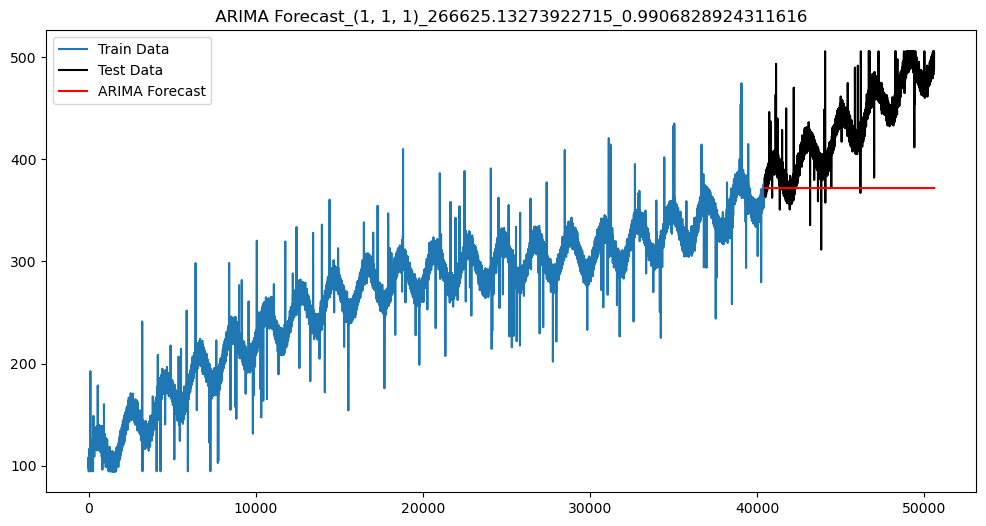

2026/01/22 21:19:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/22 21:19:19 INFO mlflow.store.db.utils: Updating database tables
2026/01/22 21:19:19 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/22 21:19:19 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/22 21:19:19 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/22 21:19:19 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/22 21:19:19 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/22 21:19:19 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/22 21:19:19 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/22 21:19:19 INFO alembic.runtime.migration: Running 

1 (2, 1, 2) 266628.65463712503 266671.6964654049 6.538702206636153 0.9906830018296707


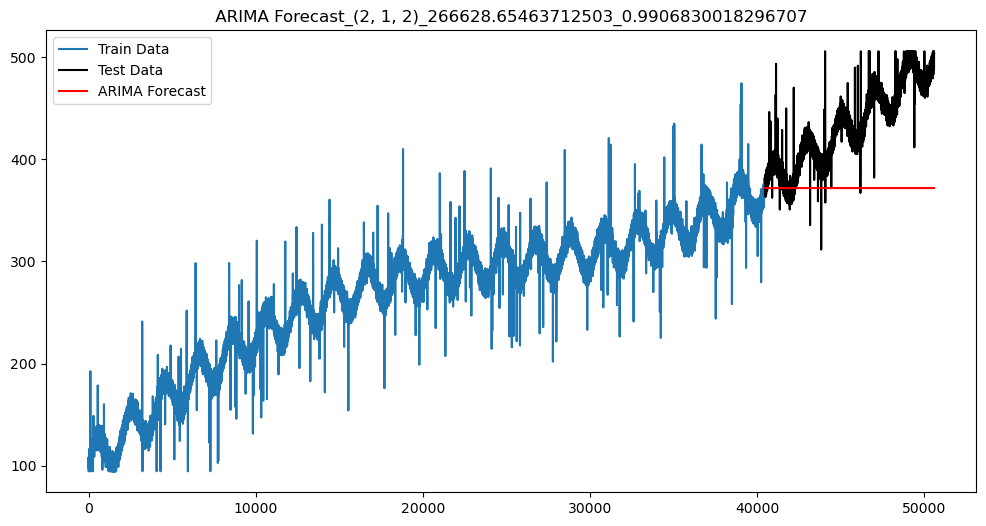

2 (3, 1, 1) 266622.17306558334 266665.2148938632 6.538181357833421 0.9906844860856936


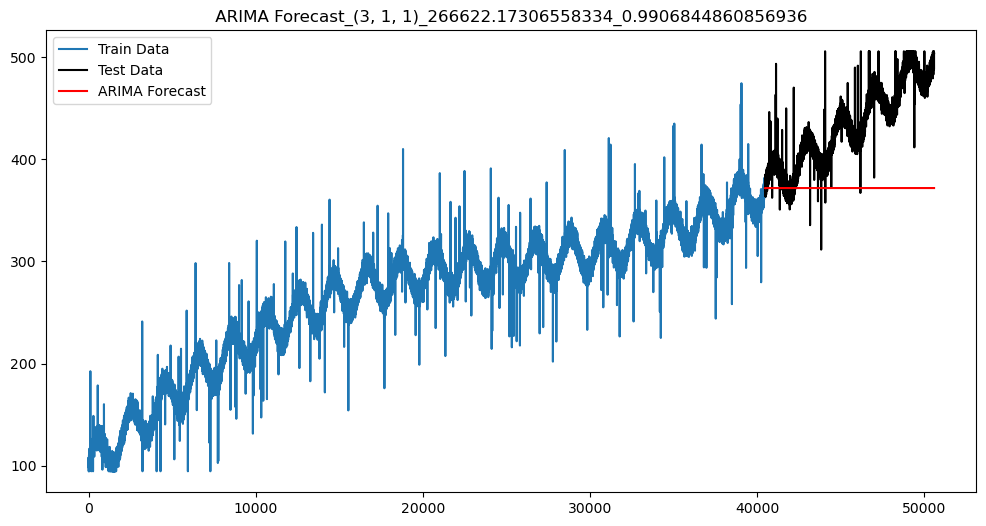

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
# 7. Fit ARIMA model (example order, adjust p and q after ACF/PACF)
orders = [(1,1,1), (2,1,2), (3,1,1)]

#with mlflow.start_run(run_name="RMSE Comparison"):

for i,order in enumerate(orders):    
    arima_model = ARIMA(train, order=order)
    arima_model_fit = arima_model.fit()
    arima_forecast = arima_model_fit.forecast(steps=len(test))
    AIC  = arima_model_fit.aic
    BIC  = arima_model_fit.bic
    RMSE = root_mean_squared_error(train, arima_model_fit.fittedvalues)
    r2   = r2_score(train, arima_model_fit.fittedvalues)
    print(i, order, AIC, BIC, RMSE, r2)
    
    # --- Plot comparison ---
    plt.figure(figsize=(12,6))
    plt.plot(train.index, train, label="Train Data")
    plt.plot(test.index, test, label="Test Data", color="black")    
    plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="red")
    plt.legend()
    plt.title(f" ARIMA Forecast_{order}_{AIC}_{r2} ")
    plt.savefig(f"ARIMA_{order}_{AIC}_{r2}.png")     
    plt.show()
    plt.close() 

    with mlflow.start_run(run_name=f"ARIMA_{order}"):
        mlflow.log_param("order", order)        
        mlflow.log_metric("AIC", float(AIC))
        mlflow.log_metric("BIC", float(BIC))
        mlflow.log_metric("RMSE", float(RMSE))
        mlflow.log_metric("r2Square", float(r2))
        mlflow.log_artifact(f"ARIMA_{order}_{AIC}_{r2}.png") 
        mlflow.sklearn.log_model(arima_model, name="ARIMA")
    
# Successfully fitted an AutoRegressive Integrated Moving Average (ARIMA) model.